# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.277311,True,3.174569
1,-0.704029,True,2.769239
2,-1.649341,False,-1.984300
3,-0.507771,False,-0.265239
4,0.035020,True,4.679703
...,...,...,...
995,1.298021,True,5.265690
996,-0.715655,False,-1.234270
997,0.437491,False,-0.225403
998,-0.581838,False,-1.420814


<AxesSubplot:xlabel='v0'>

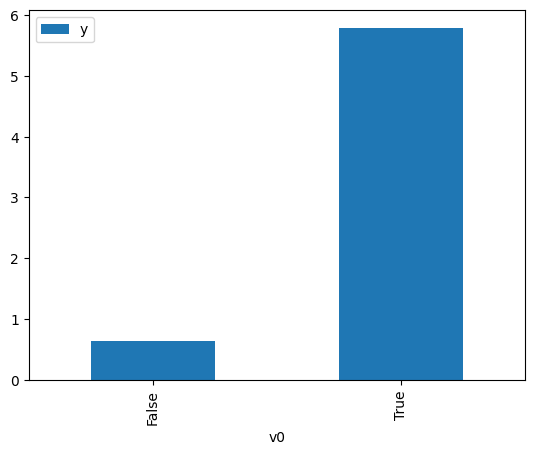

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

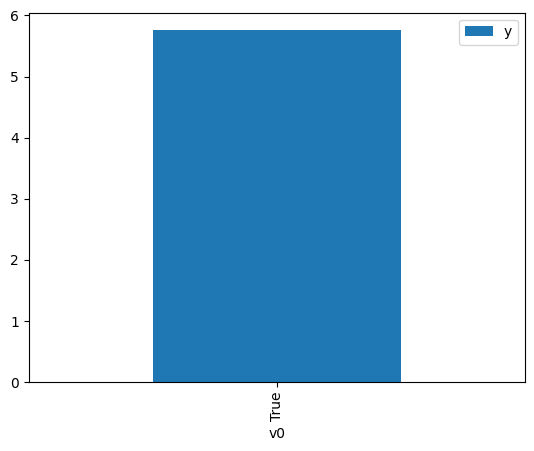

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.154328,False,-0.597742,0.554613,1.803060
1,1.168937,False,2.427070,0.103976,9.617646
2,0.497096,False,-0.176167,0.279099,3.582961
3,0.689775,False,2.251229,0.215094,4.649120
4,-0.677846,False,-0.926560,0.761005,1.314051
...,...,...,...,...,...
995,1.003350,False,-0.010709,0.135071,7.403526
996,0.324687,False,1.089527,0.345306,2.895986
997,1.847102,False,1.995969,0.033245,30.079410
998,0.849710,False,2.032636,0.170610,5.861332


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.600815,True,7.523792,0.949230,1.053486
1,1.638261,True,7.525737,0.952370,1.050012
2,-0.304114,True,5.404912,0.380377,2.628973
3,-0.865347,True,2.001182,0.183253,5.456939
4,-1.079495,True,2.476834,0.132560,7.543770
...,...,...,...,...,...
995,-0.807990,True,3.422206,0.199153,5.021275
996,1.362396,True,7.015923,0.924195,1.082023
997,0.409565,True,5.454001,0.688252,1.452957
998,-0.807990,True,3.422206,0.199153,5.021275


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                          1.524e+04
Date:                Thu, 01 Sep 2022   Prob (F-statistic):                        0.00
Time:                        16:29:24   Log-Likelihood:                         -1387.9
No. Observations:                1000   AIC:                                      2780.
Df Residuals:                     998   BIC:                                      2790.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9269      0.037     51.410      0.000       1.853       2.000
x2             5.0162      0.049    102.260      0.000       4.920       5.112
==============================================================================
Omnibus:                        2.657   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.265   Jarque-Bera (JB):                2.413
Skew:                          -0.046   Prob(JB):                        0.299
Kurtosis:                       2.778   Cond. No.                         2.13
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""